In [1]:
# Libraries required
import os
# disable all debugging logs using os.environ
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import fnmatch
import tensorflow as tf

%matplotlib inline
# plt.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
# Read and set the index to be the date

df_soil = pd.read_csv('../datasets/TX-Data/soil_station/SM_1.dat', sep=",", parse_dates=["Date"], index_col="Date")

# pandas remove spaces in the column names
df_soil.columns = df_soil.columns.str.replace(' ','')
df_soil['SWC_5'] = df_soil['SWC_5'].astype(float)
df_soil['SWC_10'] = df_soil['SWC_10'].astype(float)
df_soil['SWC_20'] = df_soil['SWC_20'].astype(float)
df_soil['SWC_50'] = df_soil['SWC_50'].astype(float)

df_soil['T_5'] = df_soil['T_5'].astype(float)
df_soil['T_10'] = df_soil['T_10'].astype(float)
df_soil['T_20'] = df_soil['T_20'].astype(float)
df_soil['T_50'] = df_soil['T_50'].astype(float)

df_soil['Ppt'] = df_soil['Ppt'].astype(float)


df_soil

,Ppt,SWC_5,SWC_10,SWC_20,SWC_50,T_5,T_10,T_20,T_50,Flag
Date,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.139,0.178,0.148,0.152,2.81,4.40,5.77,10.57,3
2015-01-01 01:00:00,0.0,0.139,0.178,0.148,0.152,2.86,4.38,5.71,10.51,3
2015-01-01 02:00:00,0.0,0.139,0.178,0.148,0.152,2.89,4.35,5.66,10.47,3
2015-01-01 03:00:00,0.0,0.139,0.178,0.148,0.152,2.90,4.33,5.62,10.41,3
2015-01-01 04:00:00,0.0,0.139,0.178,0.148,0.152,2.96,4.32,5.59,10.36,3
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 20:00:00,0.0,0.212,0.176,0.164,0.102,27.27,28.05,28.35,28.03,0
2021-09-30 21:00:00,0.0,0.212,0.176,0.164,0.102,26.81,27.62,28.08,28.05,0
2021-09-30 22:00:00,0.0,0.212,0.175,0.164,0.102,26.40,27.26,27.84,28.07,12288


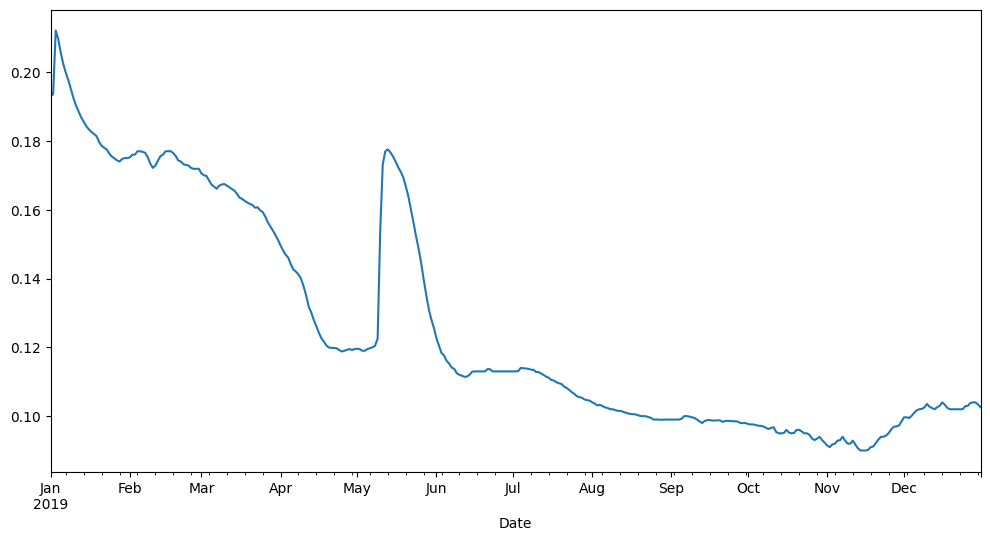

In [3]:
df_soil.loc["2019"].SWC_50.resample('D').mean().plot(figsize=(12,6))
plt.show()

In [4]:
# Read and set the index to be the date
df_met = pd.read_csv('../datasets/TX-Data/met_station/MET_1.dat', sep=",", parse_dates=["Date"], index_col="Date")

# pandas remove spaces in the column names
df_met.columns = df_met.columns.str.replace(' ','')
df_met['Ppt'] = df_met['Ppt'].astype(float)
df_met['Tair'] = df_met['Tair'].astype(float)
df_met['RH'] = df_met['RH'].astype(float)
df_met['Windspeed'] = df_met['Windspeed'].astype(float)
df_met['Winddirection'] = df_met['Winddirection'].astype(float)
df_met['Srad'] = df_met['Srad'].astype(float)

df_met

,Ppt,Tair,RH,Windspeed,Winddirection,Srad
Date,,,,,,
2014-10-01 00:00:00,0.0,22.13,80.70,1.429,203.2,0.0
2014-10-01 01:00:00,0.0,21.68,84.70,1.555,201.2,0.0
2014-10-01 02:00:00,0.0,22.21,89.20,2.288,193.1,0.0
2014-10-01 03:00:00,0.0,22.41,90.00,2.421,195.4,0.0
2014-10-01 04:00:00,0.0,22.30,92.60,1.738,191.3,0.0
...,...,...,...,...,...,...
2021-08-31 20:00:00,0.0,29.10,60.19,0.610,197.1,0.0
2021-08-31 21:00:00,0.0,28.07,62.28,0.510,199.6,0.0
2021-08-31 22:00:00,0.0,27.73,63.98,1.417,192.6,0.0


We measure air temperature, humidity, wind speed and direction, and solar radiation. Each .dat file includes the following columns:

**Date:** Synchronized time stamps (CST)

**Tair:** air temperature (deg C)

**RH:** relative humidity (percentage): https://en.wikipedia.org/wiki/Humidity

**Wind speed:** meters/second

**Wind direction:** Degree

**Srad:** solar radiation (W/m^2) https://en.wikipedia.org/wiki/Solar_irradiance



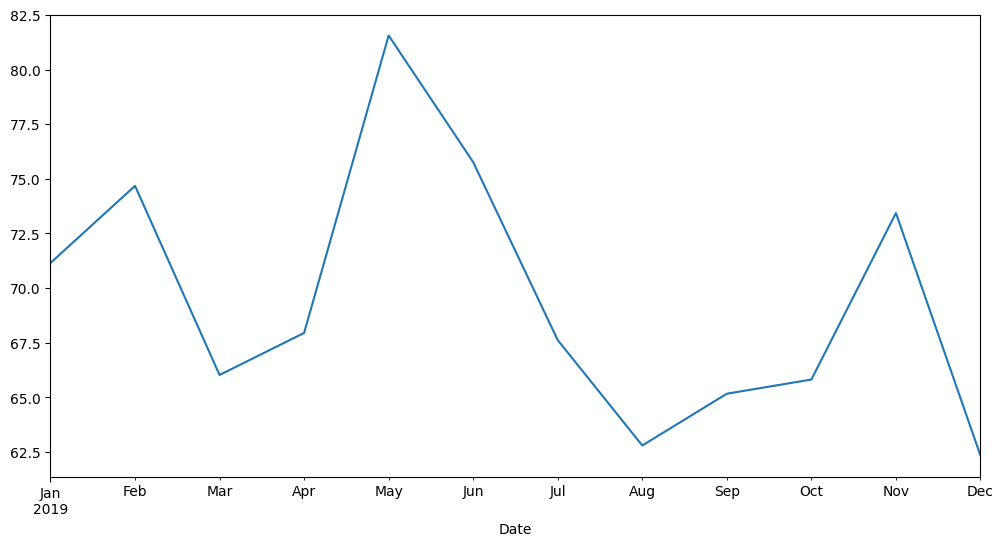

In [5]:
df_met.loc["2019"].RH.resample('M').mean().plot(figsize=(12,6))
plt.show()

In [6]:
#df.loc[(df.index < start_remove) | (df.index > end_remove)]

# We keep all of the data and we drop only the year 2018
start_remove = "2018-01"
end_remove = "2019-01"


# df = pd.merge(df_soil.loc["2019":"2021"], df_met.loc["2019":"2021"], on=["Date"])

df = pd.merge(df_soil.loc[(df_soil.index < start_remove) | (df_soil.index > end_remove)], \
              df_met.loc[(df_met.index < start_remove) | (df_met.index > end_remove)], on=["Date"])

df




,Ppt_x,SWC_5,SWC_10,SWC_20,SWC_50,T_5,T_10,T_20,T_50,Flag,Ppt_y,Tair,RH,Windspeed,Winddirection,Srad
Date,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.139,0.178,0.148,0.152,2.81,4.40,5.77,10.57,3,0.0,-1.090,81.50,1.052,52.27,0.63
2015-01-01 01:00:00,0.0,0.139,0.178,0.148,0.152,2.86,4.38,5.71,10.51,3,0.0,-1.038,81.70,0.959,46.71,0.62
2015-01-01 02:00:00,0.0,0.139,0.178,0.148,0.152,2.89,4.35,5.66,10.47,3,0.0,-0.981,82.00,1.062,52.04,0.60
2015-01-01 03:00:00,0.0,0.139,0.178,0.148,0.152,2.90,4.33,5.62,10.41,3,0.0,-0.814,81.90,0.887,58.91,0.64
2015-01-01 04:00:00,0.0,0.139,0.178,0.148,0.152,2.96,4.32,5.59,10.36,3,0.0,-0.805,90.00,0.828,16.55,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 20:00:00,0.0,0.097,0.104,0.104,0.106,34.60,34.71,33.68,29.86,0,0.0,29.100,60.19,0.610,197.10,0.00
2021-08-31 21:00:00,0.0,0.097,0.103,0.104,0.106,33.58,34.07,33.50,29.95,0,0.0,28.070,62.28,0.510,199.60,0.00
2021-08-31 22:00:00,0.0,0.096,0.103,0.103,0.106,32.75,33.46,33.23,30.03,0,0.0,27.730,63.98,1.417,192.60,0.00


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ppt_x,49680.0,0.064160,0.842752,0.000,0.000,0.000,0.000,42.160
SWC_5,49617.0,0.142099,0.052178,0.043,0.098,0.136,0.185,0.309
SWC_10,49668.0,0.153570,0.039703,0.084,0.120,0.149,0.188,0.279
SWC_20,49472.0,0.137170,0.033238,0.086,0.105,0.135,0.165,0.235
SWC_50,49655.0,0.137550,0.035043,0.087,0.104,0.130,0.169,0.239
T_5,49680.0,22.958267,9.371823,0.760,15.810,23.000,29.950,48.680
T_10,49680.0,22.973198,8.776819,1.780,16.030,23.130,30.050,43.900
T_20,49680.0,22.909138,8.299824,2.760,16.130,23.110,29.930,40.810
T_50,49680.0,22.718464,6.949271,5.960,16.560,22.615,29.090,35.260
Flag,49680.0,84.347021,933.030447,0.000,0.000,0.000,0.000,13056.000


In [8]:
# Check if Contains NaN values
df.isnull().sum()

Ppt_x              0
SWC_5             63
SWC_10            12
SWC_20           208
SWC_50            25
T_5                0
T_10               0
T_20               0
T_50               0
Flag               0
Ppt_y              1
Tair               1
RH                 1
Windspeed          1
Winddirection      1
Srad               1
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

Ppt_x            0
SWC_5            0
SWC_10           0
SWC_20           0
SWC_50           0
T_5              0
T_10             0
T_20             0
T_50             0
Flag             0
Ppt_y            0
Tair             0
RH               0
Windspeed        0
Winddirection    0
Srad             0
dtype: int64

In [10]:
# df.loc['RH'][df.loc['RH'] < 0] = 0
df.RH = np.where(df.RH < 0, 0, df.RH)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ppt_x,49414.0,0.063632,0.834896,0.000,0.00000,0.000,0.000,42.160
SWC_5,49414.0,0.142002,0.052196,0.043,0.09800,0.135,0.185,0.308
SWC_10,49414.0,0.153409,0.039716,0.084,0.12000,0.149,0.188,0.279
SWC_20,49414.0,0.137137,0.033228,0.086,0.10500,0.135,0.165,0.235
SWC_50,49414.0,0.137650,0.035090,0.087,0.10400,0.130,0.169,0.239
T_5,49414.0,22.916584,9.374674,0.760,15.77000,22.920,29.910,48.680
T_10,49414.0,22.933516,8.780362,1.780,16.00000,23.060,30.010,43.900
T_20,49414.0,22.872242,8.304660,2.760,16.10000,23.035,29.900,40.810
T_50,49414.0,22.689597,6.955883,5.960,16.52000,22.560,29.090,35.260
Flag,49414.0,69.297102,835.525970,0.000,0.00000,0.000,0.000,13056.000


Text(0, 0.5, 'Wind Velocity [m/s]')

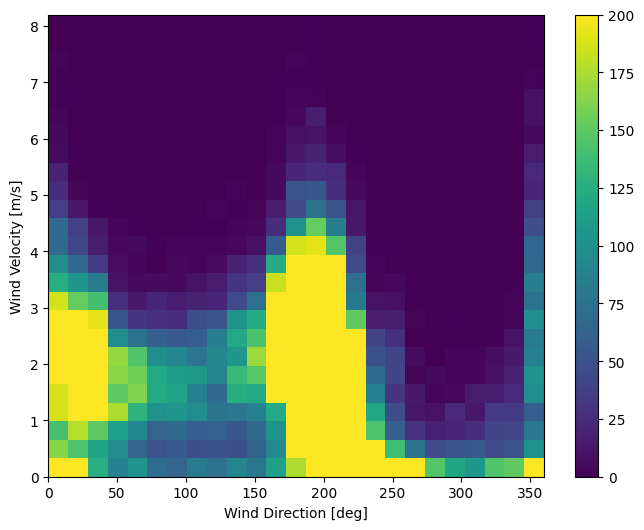

In [12]:
plt.hist2d(df['Winddirection'], df['Windspeed'], bins=(25, 25), vmax=200)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [13]:
wv = df.pop('Windspeed')
max_wv = np.max(wv)

# Convert to radians.
wd_rad = df.pop('Winddirection')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-7.808186098707588, 8.1975522162057, -3.684806881948466, 4.160795998980439)

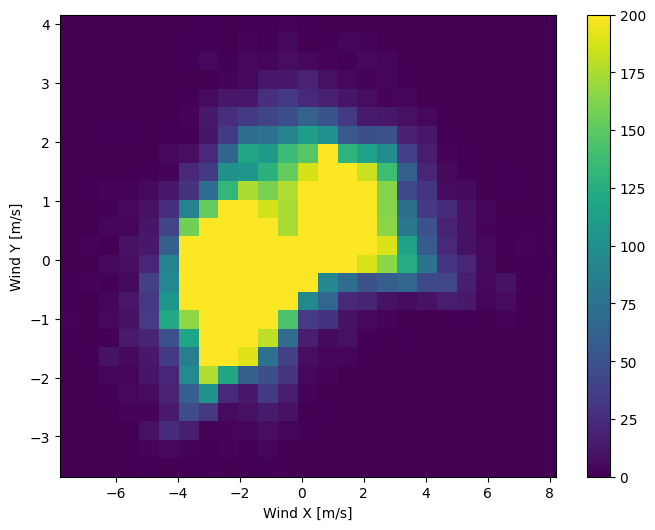

In [14]:
plt.hist2d(df['Wx'], df['Wy'], bins=(25, 25), vmax=200)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [15]:
df

,Ppt_x,SWC_5,SWC_10,SWC_20,SWC_50,T_5,T_10,T_20,T_50,Flag,Ppt_y,Tair,RH,Srad,Wx,Wy,max Wx,max Wy
Date,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.139,0.178,0.148,0.152,2.81,4.40,5.77,10.57,3,0.0,-1.090,81.50,0.63,0.643762,0.832030,5.017918,6.485406
2015-01-01 01:00:00,0.0,0.139,0.178,0.148,0.152,2.86,4.38,5.71,10.51,3,0.0,-1.038,81.70,0.62,0.657578,0.698049,5.622669,5.968718
2015-01-01 02:00:00,0.0,0.139,0.178,0.148,0.152,2.89,4.35,5.66,10.47,3,0.0,-0.981,82.00,0.60,0.653248,0.837324,5.043912,6.465211
2015-01-01 03:00:00,0.0,0.139,0.178,0.148,0.152,2.90,4.33,5.62,10.41,3,0.0,-0.814,81.90,0.64,0.458032,0.759589,4.234348,7.022129
2015-01-01 04:00:00,0.0,0.139,0.178,0.148,0.152,2.96,4.32,5.59,10.36,3,0.0,-0.805,90.00,0.20,0.793697,0.235857,7.860286,2.335786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 20:00:00,0.0,0.097,0.104,0.104,0.106,34.60,34.71,33.68,29.86,0,0.0,29.100,60.19,0.00,-0.583034,-0.179365,-7.837503,-2.411131
2021-08-31 21:00:00,0.0,0.097,0.103,0.104,0.106,33.58,34.07,33.50,29.95,0,0.0,28.070,62.28,0.00,-0.480449,-0.171080,-7.724871,-2.750703
2021-08-31 22:00:00,0.0,0.096,0.103,0.103,0.106,32.75,33.46,33.23,30.03,0,0.0,27.730,63.98,0.00,-1.382874,-0.309109,-8.002517,-1.788775


In [16]:
df = df.reset_index()
df

,Date,Ppt_x,SWC_5,SWC_10,SWC_20,SWC_50,T_5,T_10,T_20,T_50,Flag,Ppt_y,Tair,RH,Srad,Wx,Wy,max Wx,max Wy
0,2015-01-01 00:00:00,0.0,0.139,0.178,0.148,0.152,2.81,4.40,5.77,10.57,3,0.0,-1.090,81.50,0.63,0.643762,0.832030,5.017918,6.485406
1,2015-01-01 01:00:00,0.0,0.139,0.178,0.148,0.152,2.86,4.38,5.71,10.51,3,0.0,-1.038,81.70,0.62,0.657578,0.698049,5.622669,5.968718
2,2015-01-01 02:00:00,0.0,0.139,0.178,0.148,0.152,2.89,4.35,5.66,10.47,3,0.0,-0.981,82.00,0.60,0.653248,0.837324,5.043912,6.465211
3,2015-01-01 03:00:00,0.0,0.139,0.178,0.148,0.152,2.90,4.33,5.62,10.41,3,0.0,-0.814,81.90,0.64,0.458032,0.759589,4.234348,7.022129
4,2015-01-01 04:00:00,0.0,0.139,0.178,0.148,0.152,2.96,4.32,5.59,10.36,3,0.0,-0.805,90.00,0.20,0.793697,0.235857,7.860286,2.335786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49409,2021-08-31 20:00:00,0.0,0.097,0.104,0.104,0.106,34.60,34.71,33.68,29.86,0,0.0,29.100,60.19,0.00,-0.583034,-0.179365,-7.837503,-2.411131
49410,2021-08-31 21:00:00,0.0,0.097,0.103,0.104,0.106,33.58,34.07,33.50,29.95,0,0.0,28.070,62.28,0.00,-0.480449,-0.171080,-7.724871,-2.750703
49411,2021-08-31 22:00:00,0.0,0.096,0.103,0.103,0.106,32.75,33.46,33.23,30.03,0,0.0,27.730,63.98,0.00,-1.382874,-0.309109,-8.002517,-1.788775
49412,2021-08-31 23:00:00,0.0,0.096,0.102,0.104,0.106,32.07,32.89,32.94,30.13,0,0.0,27.300,67.31,0.00,-1.713485,-0.308305,-8.070404,-1.452095


In [17]:
# Convert to seconds 
timestamp_s = df['Date'].map(pd.Timestamp.timestamp)
timestamp_s

0        1.420070e+09
1        1.420074e+09
2        1.420078e+09
3        1.420081e+09
4        1.420085e+09
             ...     
49409    1.630440e+09
49410    1.630444e+09
49411    1.630447e+09
49412    1.630451e+09
49413    1.630454e+09
Name: Date, Length: 49414, dtype: float64

In [18]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


df = df.drop(['Date'], axis=1)
df

,Ppt_x,SWC_5,SWC_10,SWC_20,SWC_50,T_5,T_10,T_20,T_50,Flag,...,RH,Srad,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.0,0.139,0.178,0.148,0.152,2.81,4.40,5.77,10.57,3,...,81.50,0.63,0.643762,0.832030,5.017918,6.485406,1.232357e-12,1.000000,0.001505,0.999999
1,0.0,0.139,0.178,0.148,0.152,2.86,4.38,5.71,10.51,3,...,81.70,0.62,0.657578,0.698049,5.622669,5.968718,2.588190e-01,0.965926,0.002222,0.999998
2,0.0,0.139,0.178,0.148,0.152,2.89,4.35,5.66,10.47,3,...,82.00,0.60,0.653248,0.837324,5.043912,6.465211,5.000000e-01,0.866025,0.002939,0.999996
3,0.0,0.139,0.178,0.148,0.152,2.90,4.33,5.62,10.41,3,...,81.90,0.64,0.458032,0.759589,4.234348,7.022129,7.071068e-01,0.707107,0.003656,0.999993
4,0.0,0.139,0.178,0.148,0.152,2.96,4.32,5.59,10.36,3,...,90.00,0.20,0.793697,0.235857,7.860286,2.335786,8.660254e-01,0.500000,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49409,0.0,0.097,0.104,0.104,0.106,34.60,34.71,33.68,29.86,0,...,60.19,0.00,-0.583034,-0.179365,-7.837503,-2.411131,-8.660254e-01,0.500000,-0.865774,-0.500434
49410,0.0,0.097,0.103,0.104,0.106,33.58,34.07,33.50,29.95,0,...,62.28,0.00,-0.480449,-0.171080,-7.724871,-2.750703,-7.071068e-01,0.707107,-0.866133,-0.499814
49411,0.0,0.096,0.103,0.103,0.106,32.75,33.46,33.23,30.03,0,...,63.98,0.00,-1.382874,-0.309109,-8.002517,-1.788775,-5.000000e-01,0.866025,-0.866491,-0.499193
49412,0.0,0.096,0.102,0.104,0.106,32.07,32.89,32.94,30.13,0,...,67.31,0.00,-1.713485,-0.308305,-8.070404,-1.452095,-2.588190e-01,0.965926,-0.866849,-0.498572


In [19]:
df = df.drop([ 'Ppt_x', 'Flag', 'Ppt_y', 'SWC_10', 'SWC_20', 'SWC_50'], axis=1)

In [20]:
df

,SWC_5,T_5,T_10,T_20,T_50,Tair,RH,Srad,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.139,2.81,4.40,5.77,10.57,-1.090,81.50,0.63,0.643762,0.832030,5.017918,6.485406,1.232357e-12,1.000000,0.001505,0.999999
1,0.139,2.86,4.38,5.71,10.51,-1.038,81.70,0.62,0.657578,0.698049,5.622669,5.968718,2.588190e-01,0.965926,0.002222,0.999998
2,0.139,2.89,4.35,5.66,10.47,-0.981,82.00,0.60,0.653248,0.837324,5.043912,6.465211,5.000000e-01,0.866025,0.002939,0.999996
3,0.139,2.90,4.33,5.62,10.41,-0.814,81.90,0.64,0.458032,0.759589,4.234348,7.022129,7.071068e-01,0.707107,0.003656,0.999993
4,0.139,2.96,4.32,5.59,10.36,-0.805,90.00,0.20,0.793697,0.235857,7.860286,2.335786,8.660254e-01,0.500000,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49409,0.097,34.60,34.71,33.68,29.86,29.100,60.19,0.00,-0.583034,-0.179365,-7.837503,-2.411131,-8.660254e-01,0.500000,-0.865774,-0.500434
49410,0.097,33.58,34.07,33.50,29.95,28.070,62.28,0.00,-0.480449,-0.171080,-7.724871,-2.750703,-7.071068e-01,0.707107,-0.866133,-0.499814
49411,0.096,32.75,33.46,33.23,30.03,27.730,63.98,0.00,-1.382874,-0.309109,-8.002517,-1.788775,-5.000000e-01,0.866025,-0.866491,-0.499193
49412,0.096,32.07,32.89,32.94,30.13,27.300,67.31,0.00,-1.713485,-0.308305,-8.070404,-1.452095,-2.588190e-01,0.965926,-0.866849,-0.498572


Text(0.5, 1.0, 'Time of day signal')

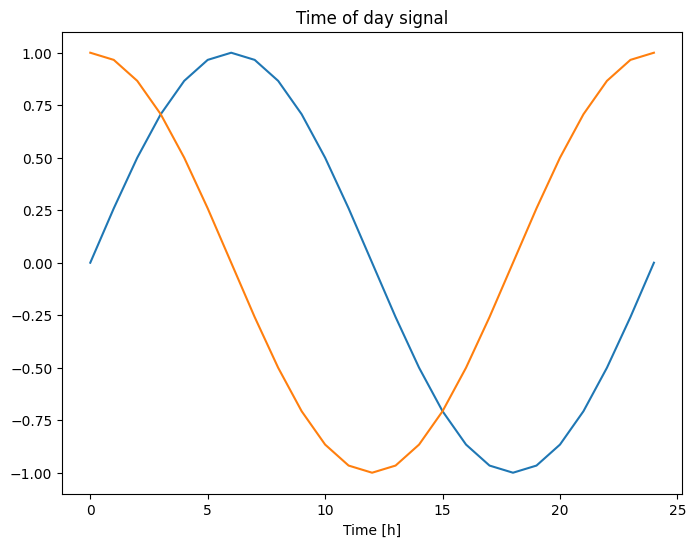

In [21]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

# Data Split



In [22]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_df

,SWC_5,T_5,T_10,T_20,T_50,Tair,RH,Srad,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.139,2.81,4.40,5.77,10.57,-1.090,81.50,0.63,0.643762,0.832030,5.017918,6.485406,1.232357e-12,1.000000,0.001505,0.999999
1,0.139,2.86,4.38,5.71,10.51,-1.038,81.70,0.62,0.657578,0.698049,5.622669,5.968718,2.588190e-01,0.965926,0.002222,0.999998
2,0.139,2.89,4.35,5.66,10.47,-0.981,82.00,0.60,0.653248,0.837324,5.043912,6.465211,5.000000e-01,0.866025,0.002939,0.999996
3,0.139,2.90,4.33,5.62,10.41,-0.814,81.90,0.64,0.458032,0.759589,4.234348,7.022129,7.071068e-01,0.707107,0.003656,0.999993
4,0.139,2.96,4.32,5.59,10.36,-0.805,90.00,0.20,0.793697,0.235857,7.860286,2.335786,8.660254e-01,0.500000,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,0.115,8.68,9.87,10.87,12.63,8.910,60.19,0.00,-1.413410,-0.653087,-7.443775,-3.439507,2.588190e-01,0.965926,-0.155623,0.987816
34585,0.114,8.49,9.62,10.64,12.66,8.630,58.09,0.00,-1.354217,-0.628606,-7.437761,-3.452494,5.000000e-01,0.866025,-0.154915,0.987928
34586,0.114,8.28,9.40,10.45,12.69,8.460,56.73,0.00,-1.343485,-0.702357,-7.266869,-3.799027,7.071068e-01,0.707107,-0.154207,0.988039
34587,0.114,8.09,9.22,10.27,12.69,8.320,51.19,0.00,-0.896631,-0.841993,-5.977543,-5.613286,8.660254e-01,0.500000,-0.153499,0.988149


# Data Normalization

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

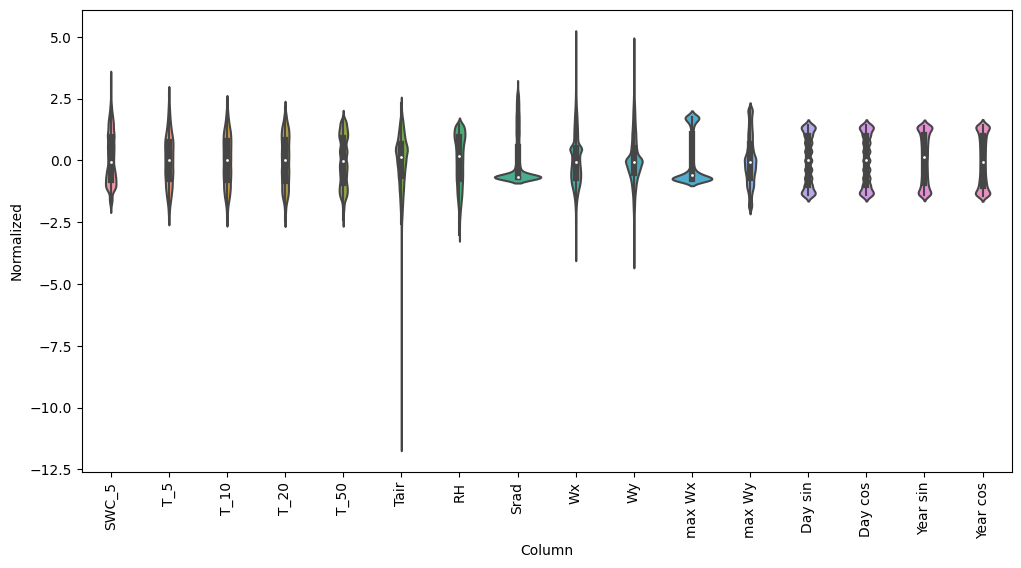

In [24]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [25]:
train_df

,SWC_5,T_5,T_10,T_20,T_50,Tair,RH,Srad,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.027035,-2.159760,-2.129483,-2.080078,-1.767079,-2.320646,0.646743,-0.683948,0.841045,0.972446,1.275170,1.678098,-0.001621,1.414282,0.001742,1.421240
1,0.027035,-2.154400,-2.131773,-2.087343,-1.775739,-2.314661,0.655787,-0.683982,0.848680,0.821358,1.369833,1.551011,0.364444,1.366100,0.002750,1.421238
2,0.027035,-2.151184,-2.135208,-2.093397,-1.781512,-2.308100,0.669353,-0.684050,0.846287,0.978415,1.279239,1.673131,0.705562,1.224839,0.003759,1.421236
3,0.027035,-2.150112,-2.137499,-2.098240,-1.790172,-2.288879,0.664831,-0.683914,0.738402,0.890755,1.152515,1.810113,0.998486,1.000124,0.004767,1.421232
4,0.027035,-2.143680,-2.138644,-2.101872,-1.797388,-2.287843,1.031109,-0.685419,0.923905,0.300154,1.720095,0.657439,1.223255,0.707271,0.005775,1.421228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,-0.447745,-1.530484,-1.503117,-1.462579,-1.469766,-1.169683,-0.316884,-0.686103,-0.295837,-0.702291,-0.675501,-0.763078,0.364444,1.366100,-0.219273,1.403918
34585,-0.467528,-1.550852,-1.531744,-1.490427,-1.465436,-1.201910,-0.411845,-0.686103,-0.263125,-0.674685,-0.674560,-0.766272,0.705562,1.224839,-0.218277,1.404076
34586,-0.467528,-1.573364,-1.556936,-1.513432,-1.461106,-1.221476,-0.473343,-0.686103,-0.257194,-0.757852,-0.647810,-0.851507,0.998486,1.000124,-0.217281,1.404234
34587,-0.467528,-1.593733,-1.577548,-1.535226,-1.461106,-1.237589,-0.723859,-0.686103,-0.010243,-0.915317,-0.445987,-1.297750,1.223255,0.707271,-0.216285,1.404390


In [26]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Days in Future Preciction

In [27]:
## Days in Future Preciction
days = 7

# Label

In [28]:
# Label
my_label="SWC_5"
no_labels = 1 

In [29]:
w1 = WindowGenerator(input_width=24*days, label_width=no_labels, shift=24*days,
                     label_columns=[my_label])
w1

Total window size: 336
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [335]
Label column name(s): ['SWC_5']

# Split

In [30]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 336, 16)
Inputs shape: (3, 168, 16)
Labels shape: (3, 1, 1)


In [32]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [34]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 168, 16), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [35]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 168, 16)
Labels shape (batch, time, features): (32, 1, 1)


In [36]:
single_step_window = WindowGenerator(
    input_width=24*days, label_width=1, shift=24*days,
    label_columns=[my_label])
single_step_window

Total window size: 336
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [335]
Label column name(s): ['SWC_5']

In [37]:
# Base Line 
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [38]:
baseline = Baseline(label_index=column_indices[my_label])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

299/299 [==============================] - 1s 2ms/step - loss: 1.2393 - mean_absolute_error: 0.8530


In [39]:
wide_window = WindowGenerator(
    input_width=24*days, label_width=24*days, shift=1,
    label_columns=[my_label])

wide_window

Total window size: 169
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65 

In [40]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 168, 16)
Output shape: (32, 168, 1)


In [41]:
def plot(self, model=None, plot_col=my_label, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

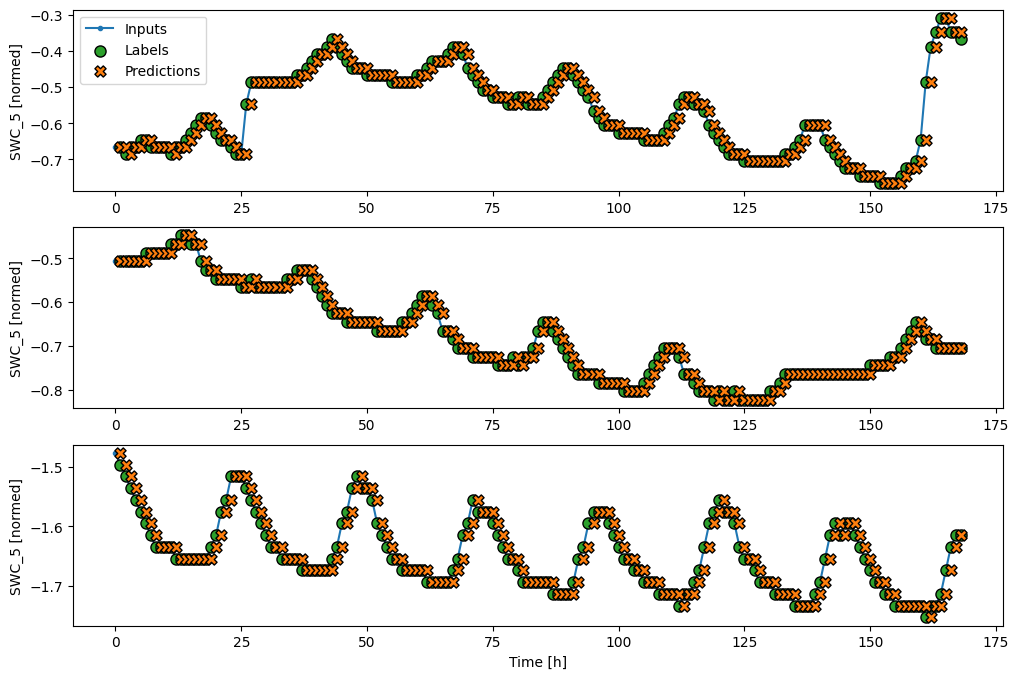

In [42]:
wide_window.plot(baseline)

# RNN

In [43]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [44]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(units=32, activation="tanh", return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 168, 16)
Output shape: (32, 168, 1)


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


In [46]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/100
1076/1076 [==============================] - 13s 9ms/step - loss: 0.0392 - mean_absolute_error: 0.0878 - val_loss: 0.0116 - val_mean_absolute_error: 0.0444
Epoch 2/100
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0318 - val_loss: 0.0067 - val_mean_absolute_error: 0.0292
Epoch 3/100
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0254 - val_loss: 0.0059 - val_mean_absolute_error: 0.0255
Epoch 4/100
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0240 - val_loss: 0.0059 - val_mean_absolute_error: 0.0260
Epoch 5/100
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0038 - mean_absolute_error: 0.0240 - val_loss: 0.0062 - val_mean_absolute_error: 0.0274
Epoch 6/100
304/304 [==============================] - 1s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0290


In [47]:
# lstm_model.build()
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 32)           6272      
                                                                 
 dense (Dense)               (None, 168, 1)            33        
                                                                 
Total params: 6,305
Trainable params: 6,305
Non-trainable params: 0
_________________________________________________________________


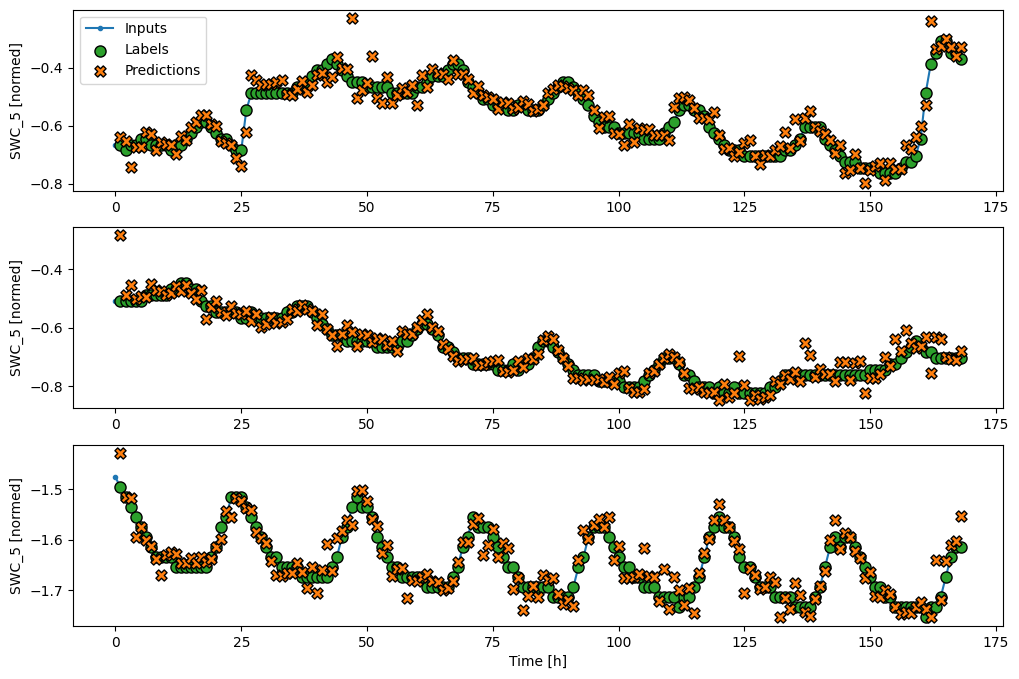

In [48]:
wide_window.plot(lstm_model)

In [49]:
performance

{'Baseline': [1.5470547676086426, 0.9413232803344727],
 'LSTM': [0.01004392746835947, 0.03650697320699692]}